### General advice (delete this cell before submitting for review)

> * When adding **Products used**, embed the hyperlink to that specific product on the DE Africa Explorer using the `[product_name](product url)` syntax.
> * When writing in Markdown cells, start each sentence on a **new line**.
This makes it easy to see changes through git commits.
> * To faciliate the easy conversion of these notebooks into a docs help page, check the [known issues](https://github.com/GeoscienceAustralia/dea-docs/wiki/Known-issues) for formatting regarding the conversion of notebooks to DE Africa docs using Sphinx.
Things to be aware of:
    * Sphinx is highly sensitive to bulleted lists:
        * Ensure that there is an empty line between any preceding text and the list
        * Only use the `*` bullet (`-` is not recognised)
        * Sublists must be indented by 4 spaces
    * Two kinds of formatting cannot be used simultaneously:
        * Hyperlinked code: \[\`code_format\`](hyperlink) fails
        * Bolded code: \*\*\`code_format\`\*\* fails
    * Headers must appear in hierachical order (`#`, `##`, `###`, `####`) and there can only be one title (`#`).
> * Use the [PEP8 standard](https://www.python.org/dev/peps/pep-0008/) for code. To make sure all code in the notebook is consistent, you can use the `jupyterlab_code_formatter` tool: select each code cell, then click `Edit` and then one of the `Apply X Formatter` options (`YAPF` or `Black` are recommended). This will reformat the code in the cell to a consistent style.
> * In the final notebook cell, include a set of relevant **keywords** which are used to build the DE Africa User Guide's [keyword Index](https://digital-earth-africa.readthedocs.io/en/latest/genindex.html).
    * Use the list of approved documentation keywords on the [wiki page](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/wiki/List-of-Documentation-Keywords).
    * Avoid using keywords that link to specific modules in `deafrica_tools`.
    * Use all lower-case (unless the tag is an acronym), separate words with spaces
    * Ensure the keywords cell below is in `Raw` format, rather than `Markdown` or `Code`.


# Spectral-temporal feature inspection tool

* **Products used:** 
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr), 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a),
[s1_rtc](https://explorer.digitalearth.africa/s2_rtc),


## Background

This notebook is an outcome of the ODC 2021 women sprint. 

Spectral-temporal features from time-series Earth observation data are often used to distinguish land cover types and monitor their evolution over time. They are particularly useful for understanding dynamic ecosystems such as wetlands.

Many methods have been developed to derive spectral and temporal features from optical or radar remote sensing data. Their effectiveness vary for different environments.
Therefore, we want to develop a tool that allows a scientist to quickly inspect well-known spectral indices and time series metrics for any location.


Contributors:

Fang Yuan, Bex Dunn, Meghan Halabisky, Kate Fickas, Allison Bailey, (add yourself here)




## Description

We want to build a tool that is:

* interactive
* using popular indicies and metrics
* easy to use for beginners wanting to learn more about remote sensing
* able to use all DE Africa input time series data
* expandable to include more spectral and temporal features.



***

## To-do list

**Completed:**
* polygon selector off map [ x ]
* sentinel 2 data [ x ]

**Must have:**
* polygon selector off map [ x ] 
* sentinel 2 data [ x ]
* all tasselled cap indices
* time series plot for each  
* DOY spectral temporal feature plot (i.e. maximum annual greenness) to show seasonal changes, color coded by year (could be continuous color palette). Example of chart concept:
<img src="https://i.ibb.co/BtCyHbg/ee-chart-DOY.png" width=800 height=800 />

* a new function that lets you do the things, or all the functionality in this notebook.
* edit the loading data function to return multiple datasets
* edit the loading data function to output the indexes loaded as string/list

**Conceptual edits to must haves**
* allow user to choose which STF or v
* remove lines from time series (just use markers)
* use plotly to be able to hover over data points


**Would like to have:** _(links to where you can get code to do this)_
* multiple datasets (add landsat data) [using load ard notebook](./Using_load_ard.ipynb)
* multiple indices (for a list, see [bandindices.py](../Tools/deafrica_tools/bandindices.py) or the [band index notebook](Calculating_band_indices.ipynb))
* sentinel 1 data [sentinel1 notebook](../Datasets/Sentinel_1.ipynb)
* spectral plot for each
* climate data [era 5 climate data notebook](../Datasets/Climate_Data_ERA5_AWS.ipynb )
* soil moisture [soil moisture notebook](../Datasets/Soil_Moisture.ipynb) 
* evapotranspiration
* phenology/metrics/cycles [Vegetation_phenology.ipynb](./Vegetation_phenology.ipynb)
* click on plotted points to retrieve the imagery for that timestamp
* trends
* statistical significance tests
        
**Handy links**    
* [ipywidgets documentation](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html) 

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.


### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [16]:
%matplotlib inline
import datetime as dt
import datacube
import numpy as np
import sys
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

## Set up a Dask cluster (disabled for now)

Dask can be used to better manage memory use and conduct the analysis in parallel.

For this notebook, we'll use dask to lazy load data over an area of interest before evaluating the results over selected polygons.

For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

To activate Dask, set up the local computing cluster using the cell below.

In [2]:
# the default function is updated to return the client so loaded data can be kept in memory later. Any change to this code will be ported back to the Tools.

import os
import dask
from datacube.utils.dask import start_local_dask
from datacube.utils.rio import configure_s3_access

def create_local_dask_cluster(
    spare_mem="3Gb", aws_unsigned=True, display_client=True, **kwargs
):
    # configure dashboard link to go over proxy
    dask.config.set(
        {
            "distributed.dashboard.link": os.environ.get(
                "JUPYTERHUB_SERVICE_PREFIX", "/"
            )
            + "proxy/{port}/status"
        }
    )

    # start up a local cluster
    client = start_local_dask(mem_safety_margin=spare_mem, **kwargs)

    ## Configure GDAL for s3 access
    configure_s3_access(aws_unsigned=aws_unsigned, client=client)

    # Show the dask cluster settings
    if display_client:
        display(client)
    
    return client

# not using dask while testing
# client = create_local_dask_cluster()

### Define some functions to load our data and run our app
Work in progress
* We have taken the notebookapp_crophealth.py script from the [Scripts](../Scripts) folder and are editing it in the cell below that starts with the line `# notebookapp_spectraltemporal.py`
* Once we have it changed to our liking, we can move the cell below into [it's own app/module](../Scripts/notebookapp_spectraltemporal.py)

The `run_spectraltemporal_app()` is moved to a cell after data is loaded.

In [3]:
# notebookapp_spectraltemporal.py
'''
This file contains functions for loading and interacting with data in the
spectral temporal widget notebook in the Frequently used code folder.

Available functions:
    load_spectraltemporal_data
    run_spectraltemporal_app

Last modified: June 2021
'''

# Load modules
from ipyleaflet import (
    Map,
    GeoJSON,
    DrawControl,
    basemaps
)
import datetime as dt
import datacube
from osgeo import ogr
import matplotlib as mpl
import matplotlib.pyplot as plt
import rasterio
from rasterio.features import geometry_mask
import xarray as xr
from IPython.display import display
import warnings
import ipywidgets as widgets
import json
import geopandas as gpd
from io import BytesIO

# Load utility functions
from deafrica_tools.datahandling import load_ard
from deafrica_tools.load_era5 import load_era5
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.bandindices import calculate_indices


def load_spectraltemporal_data(lat, lon, buffer, time):
    """
    Loads Sentinel-2 analysis-ready data (ARD) product for the case-study area over the last two years.
    Calculates indices as required using the calculate_indices script.
    Last modified: June 2021
    
    Parameters
    ----------
    lat: float
        The central latitude to analyse
    lon: float
        The central longitude to analyse
    buffer:
         The number of square degrees to load around the central latitude and longitude. 
         For reasonable loading times, set this as `0.1` or lower.

    Returns
    ----------
    ds: xarray.Dataset 
        data set containing combined, masked data
        Masked values are set to 'nan'
    """
    
    # Suppress warnings
    warnings.filterwarnings('ignore')

    # Initialise the data cube. 'app' argument is used to identify this app
    dc = datacube.Datacube(app='spectraltemporal_app')
    
    # Define area to load
    latitude = (lat - buffer, lat + buffer)
    longitude = (lon - buffer, lon + buffer)

    # Construct the data cube query for s2
    products = ["s2_l2a"]
    
    query = {
        'x': longitude,
        'y': latitude,
        'time': time,
        'measurements': [
            'red',
            'green',
            'blue',
            'nir',
            'swir_1',        
            'swir_2'
        ],
        'output_crs': 'EPSG:6933',
        'resolution': (-20, 20)
    }

    # Load the data and mask out bad quality pixels
    s2 = load_ard(dc, products=products, min_gooddata=0.5, **query)

    # Calculate the desired indices
    # e.g. ds = calculate_indices(ds, index='NDVI', collection='s2')

    s2 = calculate_indices(s2, index= ['TCW', 'TCB', 'TCG'], collection= 's2') #NOTE - this is super dodgy as these are not the coefficents for S2...
    
    # construct data query for s1
    products = ["s1_rtc"]
    
    # for now, reproject to the same grid as s2, can also use native lat/lon grid
    query = {
        'x': longitude,
        'y': latitude,
        'time': time,
        'measurements': ['vv', 'vh'],
        'output_crs': 'EPSG:6933',
        'resolution': (-20, 20)
    }

    # Load the data and mask out bad quality pixels
    s1 = load_ard(dc, products=products, min_gooddata=0.5, **query)
    
    # Caculate radar vegetation index
    s1['rvi'] = 4*s1.vh/(s1.vv+s1.vh)

    # precipitation data
    precip = load_era5('precipitation_amount_1hour_Accumulation', latitude, longitude, time, reduce_func=np.sum, resample='1D').compute()
    # rename the vararible to something easier to use
    precip = precip.rename({'precipitation_amount_1hour_Accumulation':'precip'})
    
    # Return the data
    return(s2, s1, precip)

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app='Spectral_temporal_widget')

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


## Define area and time period of interest

The area of interest (AOI) is used to pre-(lazy)-load the data and define the area to show in the interactive widget.

We use three parameters to define the AOI:

* `lat`: The central latitude to analyse (e.g. `-19.3`).
* `lon`: The central longitude to analyse (e.g. `23.3`).
* `buffer`: The number of square degrees to load around the central latitude and longitude.

Keep the AOI small for testing.
When the tool is working and dask is implemented, it will be easier to work with larger AOI.

In [5]:
# Define the area of interest for the analysis
lat = -19.382666
lon = 23.240463
buffer = 0.005

Allow selection of time period. Use two years for now.

Noting ERA5 climate data is only updated monthly, so including recent dates might fail.

In [6]:
time = '2019', '2020'

### Load data
The `load_spectraltemporal_data()` command performs several key steps:

* identify all available Sentinel-2, Sentinel-1 and climiate data in the case-study area over the two years
* remove any bad quality pixels
* keep images where more than half of the image contains good quality pixels
* calculate indices
* return the collated data for analysis

The function returns cleaned and collated `dataset` objects.
As the command runs, feedback will be provided below the cell, including information on the number of cleaned images loaded from each sensor.

The function takes four arguments: `lat`, `lon`, `buffer` and `time`.
These determine the area of interest and time period of interest that the function loads, and can be changed in the previous cell.

**Please be patient**.
The load is complete when the cell status goes from `[*]` to `[number]`.

**Once the widget UI is finalized. We should use dask to not load all data upfront. This will avoid unnecessary data loading and make this tool faster.**

In [7]:
# load the data based off our set parameters
datasets = load_spectraltemporal_data(lat, lon, buffer, time) ###FIXME update this function to take a string index identifier or a list of indices as an input variable

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 114 out of 147 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 114 time steps
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Counting good quality pixels for each time step
Filtering to 60 out of 60 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 60 time steps


In [8]:
# results are a list of three datasets
datasets

(<xarray.Dataset>
 Dimensions:      (time: 114, x: 49, y: 61)
 Coordinates:
   * time         (time) datetime64[ns] 2019-01-21T08:45:40 ... 2020-12-26T08:...
   * y            (y) float64 -2.426e+06 -2.426e+06 ... -2.428e+06 -2.428e+06
   * x            (x) float64 2.242e+06 2.242e+06 ... 2.243e+06 2.243e+06
     spatial_ref  int32 6933
 Data variables:
     red          (time, y, x) float32 602.0 628.0 621.0 ... 1932.0 1636.0 nan
     green        (time, y, x) float32 637.0 669.0 698.0 ... 2052.0 1876.0 nan
     blue         (time, y, x) float32 412.0 418.0 419.0 ... 1758.0 1744.0 nan
     nir          (time, y, x) float32 1789.0 1954.0 2100.0 ... 3146.0 3130.0 nan
     swir_1       (time, y, x) float32 2013.0 2005.0 2036.0 ... 2905.0 2830.0 nan
     swir_2       (time, y, x) float32 1185.0 1173.0 1192.0 ... 2355.0 2300.0 nan
     TCW          (time, y, x) float32 -0.14803416 -0.14265434 ... -0.1890683 nan
     TCB          (time, y, x) float32 0.20646015 0.21884865 ... 0.41914013 nan

## Run the spectraltemporal app
The `run_spectraltemporal_app()` command launches an interactive map.
Drawing polygons within the red boundary (which represents the area covered by the loaded data) will result in plots of the average NDVI in that area.
Draw polygons by clicking the &#11039; symbol in the app.

The function works by taking the loaded data `dataset` as an argument, as well as the `lat`, `lon`, and `buffer` parameters used to define the spatial extent.

> **Note:** data points will only appear for images where more than 50% of the pixels were classified as good quality. This may cause trend lines on the average NDVI plot to appear disconnected. Available data points will be marked with the `*` symbol.

In [9]:
# moved here to be close to the widget cell
# now that the data is loaded, we can just tweak this function until the widget works as expected.

# !!! Be aware that this function is very hard to debug because it doesn't display error messages....

def run_spectraltemporal_app(s2, s1, era5, lat, lon, buffer):
    """
    Plots an interactive map of the case-study area and allows
    the user to draw polygons. This returns a plot of the average NDVI value
    in the polygon area.
    Last modified: June 2021
    
    Parameters
    ----------
    ds: xarray.Dataset 
        data set containing combined, masked data
        Masked values are set to 'nan'
    lat: float
        The central latitude corresponding to the area of loaded ds
    lon: float
        The central longitude corresponding to the area of loaded ds
    buffer:
         The number of square degrees to load around the central latitude and longitude. 
         For reasonable loading times, set this as `0.1` or lower.
    """
    
    # Suppress warnings
    warnings.filterwarnings('ignore')

    # Update plotting functionality through rcParams
    mpl.rcParams.update({'figure.autolayout': True})
    
    # Define polygon bounds   
    latitude = (lat - buffer, lat + buffer)
    longitude = (lon - buffer, lon + buffer)

    # Define the bounding box that will be overlayed on the interactive map
    # The bounds are hard-coded to match those from the loaded data
    geom_obj = {
        "type": "Feature",
        "properties": {
            "style": {
                "stroke": True,
                "color": 'red',
                "weight": 4,
                "opacity": 0.8,
                "fill": True,
                "fillColor": False,
                "fillOpacity": 0,
                "showArea": True,
                "clickable": True
            }
        },
        "geometry": {
            "type": "Polygon",
            "coordinates": [
                [
                    [
                        longitude[0],
                        latitude[0]
                    ],
                    [
                        longitude[1],
                        latitude[0]
                    ],
                    [
                        longitude[1],
                        latitude[1]
                    ],
                    [
                        longitude[0],
                        latitude[1]
                    ],
                    [
                        longitude[0],
                        latitude[0]
                    ]
                ]
            ]
        }
    }
    
    # Create a map geometry from the geom_obj dictionary
    # center specifies where the background map view should focus on
    # zoom specifies how zoomed in the background map should be
    loadeddata_geometry = ogr.CreateGeometryFromJson(str(geom_obj['geometry']))
    loadeddata_center = [
        loadeddata_geometry.Centroid().GetY(),
        loadeddata_geometry.Centroid().GetX()
    ]
    loadeddata_zoom = 16

    # define the study area map
    studyarea_map = Map(
        center=loadeddata_center,
        zoom=loadeddata_zoom,
        basemap=basemaps.Esri.WorldImagery
    )

    # define the drawing controls
    studyarea_drawctrl = DrawControl(
        polygon={"shapeOptions": {"fillOpacity": 0}},
        marker={},
        circle={},
        circlemarker={},
        polyline={},
    )

    # add drawing controls and data bound geometry to the map
    studyarea_map.add_control(studyarea_drawctrl)
    studyarea_map.add_layer(GeoJSON(data=geom_obj))

    # Index to count drawn polygons
    polygon_number = 0

    # Define widgets to interact with
    instruction = widgets.Output(layout={'border': '1px solid black'})
    with instruction:
        print("Draw a polygon within the red box to view time series plots")  #!!!!!!!!!!!!! Edit to give more instructions

    info = widgets.Output(layout={'border': '1px solid black'})
    with info:
        print("Plot status:")

    fig_display = widgets.Output(layout=widgets.Layout(
        width="50%",  # proportion of horizontal space taken by plot
    ))

    #!!!!!!!!!!!Edit this section to set up multiple plots.
    # number of plots needs to match the variables to be displayed.
    # if more plots are needed, the layout can be redesigned
    with fig_display:
        plt.ioff()
        fig, ax = plt.subplots(5, 1, figsize=(8, 12), sharex=True)
        # use automatically generated limits?
        #ax.set_ylim([0, 1]) - these limits won't work for the tasseled cap indices. need to set graph limits as a #FIXME
        #ax[0].set_ylim([-1,1]) #- try this. I think this is using a "normalised" tci formula

    colour_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
  
    # Function to execute each time something is drawn on the map
    def handle_draw(self, action, geo_json):
        nonlocal polygon_number

        # Execute behaviour based on what the user draws
        if geo_json['geometry']['type'] == 'Polygon':

            info.clear_output(wait=True)  # wait=True reduces flicker effect
            
            # Save geojson polygon to io temporary file to be rasterized later
            jsonData = json.dumps(geo_json)
            binaryData = jsonData.encode()
            io = BytesIO(binaryData)
            io.seek(0)
            
            # Read the polygon as a geopandas dataframe
            gdf = gpd.read_file(io)
            gdf.crs = "EPSG:4326"
                
            colour = colour_list[polygon_number % len(colour_list)]

            # Add a layer to the map to make the most recently drawn polygon
            # the same colour as the line on the plot
            studyarea_map.add_layer(
                GeoJSON(
                    data=geo_json,
                    style={
                        'color': colour,
                        'opacity': 1,
                        'weight': 4.5,
                        'fillOpacity': 0.0
                    }
                )
            )

            ax_idx = 0
            
            # Section for S2
            # ===================
            # Convert the drawn geometry to pixel coordinates to be used as a mask
            xr_poly = xr_rasterize(gdf, s2)
            
            for var in ['TCW', 'TCG', 'TCB']:
                # Construct a mask to only select pixels within the drawn polygon
                masked_ds_mean = s2[var].where(xr_poly).mean(dim=['x', 'y'], skipna=True)
        
                # add new data to the plot
                xr.plot.plot(
                    masked_ds_mean,
                    marker='*',
                    color=colour,
                    ax=ax[ax_idx]
                )

                # reset titles back to custom
                ax[ax_idx].set_title(var) #FIXME set index/indices as a variable
                ax[ax_idx].set_xlabel("")
                ax[ax_idx].set_ylabel("index")
                ax_idx +=1
                
            # section for S1
            # ==========================
            # Convert the drawn geometry to pixel coordinates to be used as a mask
            s1_mask = xr_rasterize(gdf, s1)
            
            for var in ['rvi']:
                # Construct a mask to only select pixels within the drawn polygon
                masked_s1_mean = s1[var].where(s1_mask).mean(dim=['x', 'y'], skipna=True)
        
                # add new data to the plot
                xr.plot.plot(
                    masked_s1_mean,
                    marker='*',
                    color=colour,
                    ax=ax[ax_idx]
                )

                # reset titles back to custom
                ax[ax_idx].set_title(var) #FIXME set index/indices as a variable
                ax[ax_idx].set_xlabel("")
                ax[ax_idx].set_ylabel("index")
                ax_idx +=1

            # section for climate
            # ==========================
            # Convert the drawn geometry to pixel coordinates to be used as a mask
            # masking is disabled because ERA5 has low resolution
            # for the test AOI, ERA5 has one grid cell, rasterize doesn't work
            # era5_mask = xr_rasterize(gdf, era5)
            
            for var in ['precip']:
                # Construct a mask to only select pixels within the drawn polygon
                masked_era5_mean = era5[var].mean(dim=['lat', 'lon'], skipna=True)

                # add new data to the plot
                xr.plot.plot(
                    masked_era5_mean,
                    marker='*',
                    color=colour,
                    ax=ax[ax_idx]
                )

                # reset titles back to custom
                ax[ax_idx].set_title(var) #FIXME set index/indices as a variable
                ax[ax_idx].set_ylabel("index")
                ax_idx +=1

            ax[-1].set_xlabel("Date")

                       
            # refresh display
            fig_display.clear_output(wait=True)  # wait=True reduces flicker effect
            with fig_display:
                display(fig)
                
            with info:
                print("Plot status: polygon sucessfully added to plot.")

            # Iterate the polygon number before drawing another polygon
            polygon_number = polygon_number + 1

        else:
            info.clear_output(wait=True)
            with info:
                print("Plot status: this drawing tool is not currently "
                      "supported. Please use the polygon tool.")

    # call to say activate handle_draw function on draw
    studyarea_drawctrl.on_draw(handle_draw)

    with fig_display:
        # TODO: update with user friendly something
        display(widgets.HTML(""))

    # Construct UI:
    #  +-----------------------+
    #  | instruction           |
    #  +-----------+-----------+
    #  |  map      |  plot     |
    #  |           |           |
    #  +-----------+-----------+
    #  | info                  |
    #  +-----------------------+
    ui = widgets.VBox([instruction,
                       widgets.HBox([studyarea_map, fig_display]), #add more boxes to the layout to add more plots
                       info])
    display(ui)
    

# Alternative UI design?

    # Construct UI:
    #  +-----------------------+
    #  | instruction           |
    #  +-----------+-----------+
    #  |  map      / info      |
    #  |                       |
    #  +-----------+-----------+
    #  /  plot grid            /
    #  /                       /
    #  +-----------+-----------+


In [10]:
# run the app
run_spectraltemporal_app(datasets[0], datasets[1], datasets[2], lat, lon, buffer)

## More wetland stuff

### Phenology plot app
 * working on getting the colorbar to look nice with the years when there are less than 5 years
 * checking that dates are ordered 
 * to do - load landsat above here - looks way nicer with more years

<Figure size 432x288 with 0 Axes>

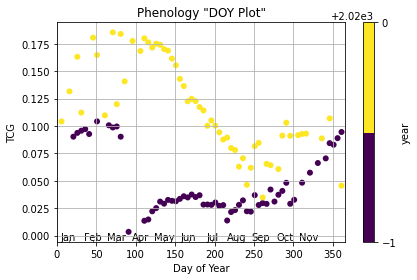

In [64]:
plt.clf()

#ok, let's grab the TCG an xarray.Dataset with dimensions ('time', 'y', 'x') out of our list of datasets above
TCG_ds = datasets[0].TCG.mean(dim=['x','y']) #taking the mean to see if I can get the plot working

fig, ax = plt.subplots()

#how many years are in our database?
n_years = len(set(TCG_ds['time.year'].data))
#get one color per year
cmap = mpl.cm.get_cmap('viridis',n_years) #specify how many colours we want out of the color map

#--working--#
bounds = list(set(TCG_ds['time.year'].data)) #get list of unique years
norm = mpl.colors.BoundaryNorm(bounds, n_years)

# Grabbing the day of year (for xaxis) and year (for color) made easier with xarray
sp = ax.scatter(TCG_ds['time.dayofyear'], TCG_ds, c=TCG_ds['time.year'],
                cmap=cmap, marker='o', edgecolor='none')#, s=35)
fig.colorbar(sp, ticks=bounds, label ='year')

# If you want the months to show up as minor ticks...
month_doys = [dt.date(2000, m, 15).timetuple().tm_yday for m in range(1, 13)]
months = mpl.ticker.FixedLocator(month_doys)
months_fmrt = mpl.dates.DateFormatter('%b') 

ax.xaxis.set_ticks(month_doys, minor=True)
ax.tick_params(axis='x', which='minor', direction='in', pad=-10)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(months_fmrt)


# Labels and axis limits are good
ax.grid(True)
ax.set_xlim((0, 366))
#ax.set_ylim((0, 1))
ax.set_xlabel('Day of Year')
ax.set_ylabel('TCG')
ax.set_title('Phenology "DOY Plot"')


plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [18]:
print(datacube.__version__)

1.8.4.dev81+g80d466a2


**Last Tested:**

In [19]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-06-24'